<a href="https://colab.research.google.com/github/pea-sys/Til/blob/master/AutoFeatureEngineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 遺伝的アルゴリズムによる特徴量自動生成
Kaggleで使えるか試す前に写経実行してみた。  
自動生成される特徴量が有効ならば利用したい。  
[遺伝的アルゴリズム](https://qiita.com/overlap/items/e7f1077ef8239f454602)  

## 遺伝的アルゴリズム

In [0]:
!pip install deap

     |████████████████████████████████| 153kB 2.8MB/s 


In [0]:
import warnings
warnings.filterwarnings('ignore')

   	      	                     fitness                      	                      size                     
   	      	--------------------------------------------------	-----------------------------------------------
gen	nevals	avg    	gen	max    	min    	nevals	std       	avg    	gen	max	min	nevals	std    
0  	300   	0.73583	0  	0.74323	0.72951	300   	0.00224383	4.52667	0  	14 	2  	300   	2.84182
1  	149   	0.738391	1  	0.745901	0.731518	149   	0.00282303	4.32333	1  	15 	1  	149   	2.99757
2  	170   	0.740125	2  	0.747869	0.73084 	170   	0.00351079	4.10667	2  	16 	1  	170   	3.19405
3  	168   	0.740921	3  	0.747869	0.731056	168   	0.00384565	4.42   	3  	14 	1  	168   	2.88853
4  	173   	0.742479	4  	0.767069	0.732135	173   	0.00495049	4.33   	4  	13 	1  	173   	2.17894
5  	174   	0.746138	5  	0.767069	0.731941	174   	0.00774637	3.39667	5  	9  	1  	174   	0.97262
6  	140   	0.753427	6  	0.768435	0.73219 	140   	0.0128409 	3.56667	6  	9  	1  	140   	1.06406
7  	173   	0.758359	7  	0.

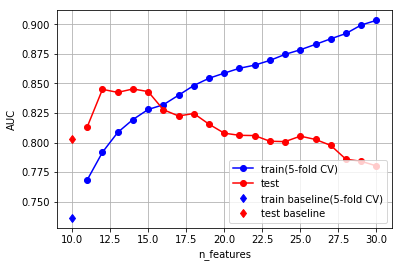

In [0]:
import operator, math, random, time
import numpy as np

from deap import algorithms, base, creator, tools, gp

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, log_loss

import matplotlib.pyplot as plt

# サンプルデータの生成
X, y = make_classification(n_samples=1000, n_features=10, n_informative=5, n_redundant=0, n_repeated=0,
                           n_clusters_per_class=8, random_state=123)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# ベースラインスコアの算出
clf = LogisticRegression(penalty="l2", C=1.0)
base_train_auc = np.mean(cross_val_score(clf, X_train, y_train, scoring="roc_auc", cv=5))
clf.fit(X_train, y_train)
base_test_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])

# 除算関数の定義
# 左項 / 右項で右項が0の場合1を代入する
def protectedDiv(left, right):
    eps = 1.0e-7
    tmp = np.zeros(len(left))
    tmp[np.abs(right) >= eps] = left[np.abs(right) >= eps] / right[np.abs(right) >= eps]
    tmp[np.abs(right) < eps] = 1.0
    return tmp


# 乱数シード
random.seed(123)

# 適合度を最大化するような木構造を個体として定義
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMax)

# 初期値の計算
# 学習データの5-fold CVのAUCスコアを評価指標の初期値とする
n_features = X_train.shape[1]
clf = LogisticRegression(penalty="l2", C=1.0)
prev_auc = np.mean(cross_val_score(clf, X_train, y_train, scoring="roc_auc", cv=5))

# メインループ
# resultsに特徴量数、学習データのAUCスコア（5-fold CV）、テストデータのAUCスコアを保持する
# exprsに生成された特徴量の表記を保持する
results = []
exprs = []
for i in range(100):
    # 構文木として利用可能な演算の定義
    pset = gp.PrimitiveSet("MAIN", n_features)
    pset.addPrimitive(operator.add, 2)
    pset.addPrimitive(operator.sub, 2)
    pset.addPrimitive(operator.mul, 2)
    pset.addPrimitive(protectedDiv, 2)
    pset.addPrimitive(operator.neg, 1)
    pset.addPrimitive(np.cos, 1)
    pset.addPrimitive(np.sin, 1)
    pset.addPrimitive(np.tan, 1)

    # 関数のデフォルト値の設定
    toolbox = base.Toolbox()
    toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=3)
    toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register("compile", gp.compile, pset=pset)

    # 評価関数の設定
    # 新しく生成した変数を元の変数に加えて5-fold CVを求める
    def eval_genfeat(individual):
        func = toolbox.compile(expr=individual)
        features_train = [X_train[:,i] for i in range(n_features)]
        new_feat_train = func(*features_train)
        X_train_tmp = np.c_[X_train, new_feat_train]
        return np.mean(cross_val_score(clf, X_train_tmp, y_train, scoring="roc_auc", cv=5)),

    # 評価、選択、交叉、突然変異の設定
    # 選択はサイズ10のトーナメント方式、交叉は1点交叉、突然変異は深さ2のランダム構文木生成と定義
    toolbox.register("evaluate", eval_genfeat)
    toolbox.register("select", tools.selTournament, tournsize=10)
    toolbox.register("mate", gp.cxOnePoint)
    toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
    toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

    # 構文木の制約の設定
    # 交叉や突然変異で深さ5以上の木ができないようにする
    toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=5))
    toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=5)) 

    # 世代ごとの個体とベスト解を保持するクラスの生成
    pop = toolbox.population(n=300)
    hof = tools.HallOfFame(1)

    # 統計量の表示設定
    stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
    stats_size = tools.Statistics(len)
    mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
    mstats.register("avg", np.mean)
    mstats.register("std", np.std)
    mstats.register("min", np.min)
    mstats.register("max", np.max)

    # 進化の実行
    # 交叉確率50%、突然変異確率10%、10世代まで進化
    start_time = time.time()
    pop, log = algorithms.eaSimple(pop, toolbox, 0.5, 0.1, 10, stats=mstats, halloffame=hof, verbose=True)
    end_time = time.time()

    # ベスト解とAUCの保持
    best_expr = hof[0]
    best_auc = mstats.compile(pop)["fitness"]["max"]

    # 5-fold CVのAUCスコアが前ステップのAUCを超えていた場合
    # 生成変数を学習、テストデータに追加し、ベストAUCを更新する
    if prev_auc < best_auc:
        # 生成変数の追加
        func = toolbox.compile(expr=best_expr)
        features_train = [X_train[:,i] for i in range(n_features)]
        features_test = [X_test[:,i] for i in range(n_features)]
        new_feat_train = func(*features_train)
        new_feat_test = func(*features_test)
        X_train = np.c_[X_train, new_feat_train]
        X_test = np.c_[X_test, new_feat_test]

        ### テストAUCの計算（プロット用）
        clf.fit(X_train, y_train)
        train_auc = roc_auc_score(y_train, clf.predict_proba(X_train)[:,1])
        test_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])

        # ベストAUCの更新と特徴量数の加算
        prev_auc = best_auc
        n_features += 1

        # 表示と出力用データの保持
        print(n_features, best_auc, train_auc, test_auc, end_time - start_time)
        results.append([n_features, best_auc, train_auc, test_auc])
        exprs.append(best_expr)

        # 変数追加後の特徴量数が30を超えた場合break
        if n_features >= 30:
            break

# 結果の出力
print()
print("### Results")
print("Baseline AUC train :", base_train_auc)
print("Baseline AUC test :", base_test_auc)
print("Best AUC train :", results[-1][1])
print("Best AUC test :", results[-1][3])

# 結果のプロット
res = np.array(results)
plt.plot(res[:,0], res[:,1],"o-", color="b", label="train(5-fold CV)")
plt.plot(res[:,0], res[:,3],"o-", color="r", label="test")
plt.plot(10, base_train_auc, "d", color="b", label = "train baseline(5-fold CV)")
plt.plot(10, base_test_auc, "d", color="r", label = "test baseline")
plt.xlim(9,31)
plt.grid(which="both")
plt.xlabel('n_features')
plt.ylabel('AUC')
plt.legend(loc="lower right")
plt.savefig("gp_featgen.png")

# 生成した構文木の出力
print()
print("### Generated feature expression")
for expr in exprs:
    print(expr)

## 感想
GoogleColabだとセッション切れになってしまったりしたので、データ数を10000から1000に減らした。  
自分では作れないような特徴量が沢山できた。
特徴が増える毎に訓練データの精度は上がっていったが、汎化性能は落ちた。  
オーバーフィット。ただ、追加される特徴はラベルと相関がありそうで
試す価値はありそうだ。  
データセットが十分あるなら使えそう。
データセットが少ない場合でも、一部の特徴量だけ採用してチューニングするアプローチもある。
他にも特徴生成の手段としてfeaturetoolというものがあるそうなので
いずれ試してみたいところ。  
やっぱり、計算量多くなるとGCEを使った方が良さそうだ。
